In [11]:
%load_ext autoreload
%autoreload 2
from lib.ekyn import *
from sklearn.model_selection import train_test_split
from torch import bincount
from lib.utils import plot_eeg_and_labels
from lib.models import MLP
from tqdm import tqdm
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader,Dataset
import torch
import numpy as np
import random
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.env import DEVICE
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
from lib.utils import Windowset
CONFIG = {
    'BATCH_SIZE':512,
    'LEARNING_RATE':3e-4,
    'WINDOW_SIZE':1,
    'STARTING_FILTERS':4,
    'N_BLOCKS':3
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
trainloader = DataLoader(Windowset(*load_eeg_label_pairs(ids=train_idx),CONFIG['WINDOW_SIZE']),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)
devloader = DataLoader(Windowset(*load_eeg_label_pairs(ids=test_idx),CONFIG['WINDOW_SIZE']),batch_size=CONFIG['BATCH_SIZE'],shuffle=False)

In [13]:
from lib.models import ResNetv3
model = ResNetv3(windowsize=CONFIG['WINDOW_SIZE'], starting_filters=CONFIG['STARTING_FILTERS'], n_blocks=CONFIG['N_BLOCKS']).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716])).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=CONFIG['LEARNING_RATE'])
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

lossi = []
trainlossi = []
devlossi = []

Params:  26831


In [4]:
model.train()
for epoch in tqdm(range(10)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(DEVICE),yi.to(DEVICE)
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
    # if epoch % 1 == 0:
    #     plt.plot(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))
    #     plt.savefig('loss.jpg')
    #     plt.close()

    #     loss,_,_,_,_ = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=DEVICE)
    #     trainlossi.append(loss)
    #     loss,_,_,_,_ = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
    #     devlossi.append(loss)
    #     print(loss)

    #     plt.plot(trainlossi)
    #     plt.plot(devlossi)
    #     plt.savefig('dev.jpg')
    #     plt.close()

100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


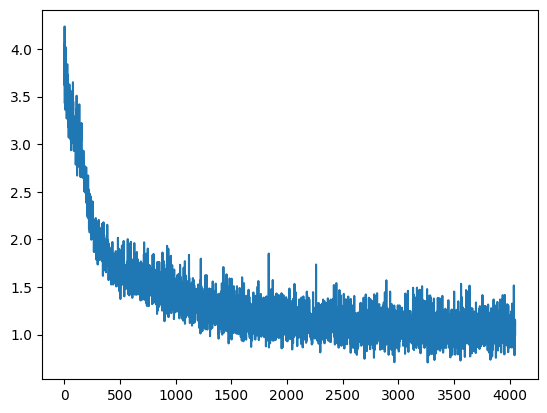

In [5]:
plt.plot(lossi)

In [6]:
print(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1)[-1])

tensor(1.0040)


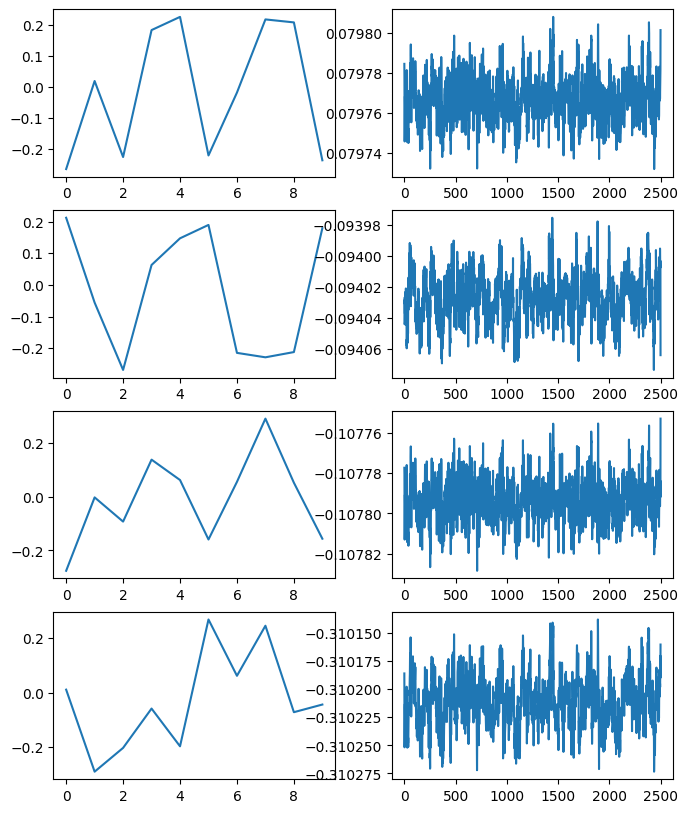

In [7]:
model.to('cpu')
Xi,yi = next(iter(trainloader))

fig,ax = plt.subplots(nrows=len(model.c1.weight),ncols=2,figsize=(8,10))
for i,kernel in enumerate(model.c1.weight.squeeze().detach()):
    ax[i,0].plot(kernel)
for i,kernel in enumerate(model.c1(Xi.reshape(-1,1,5000)).detach()[0]):
    ax[i,1].plot(kernel)

100%|██████████| 405/405 [00:06<00:00, 61.79it/s]


              precision    recall  f1-score   support

         0.0       0.47      0.90      0.62     11279
         1.0       0.91      0.91      0.91     90907
         2.0       0.91      0.83      0.87    105174

    accuracy                           0.87    207360
   macro avg       0.77      0.88      0.80    207360
weighted avg       0.89      0.87      0.87    207360

0.9976050853729248


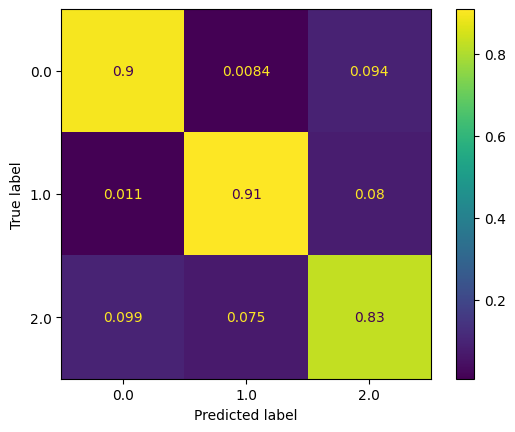

In [8]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

100%|██████████| 135/135 [00:02<00:00, 59.14it/s]


              precision    recall  f1-score   support

         0.0       0.50      0.76      0.60      3504
         1.0       0.91      0.93      0.92     31617
         2.0       0.91      0.85      0.88     33999

    accuracy                           0.88     69120
   macro avg       0.78      0.85      0.80     69120
weighted avg       0.89      0.88      0.88     69120

1.1847885012626649


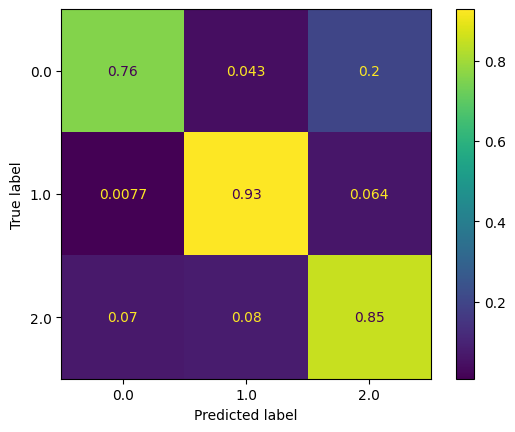

In [9]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

[]

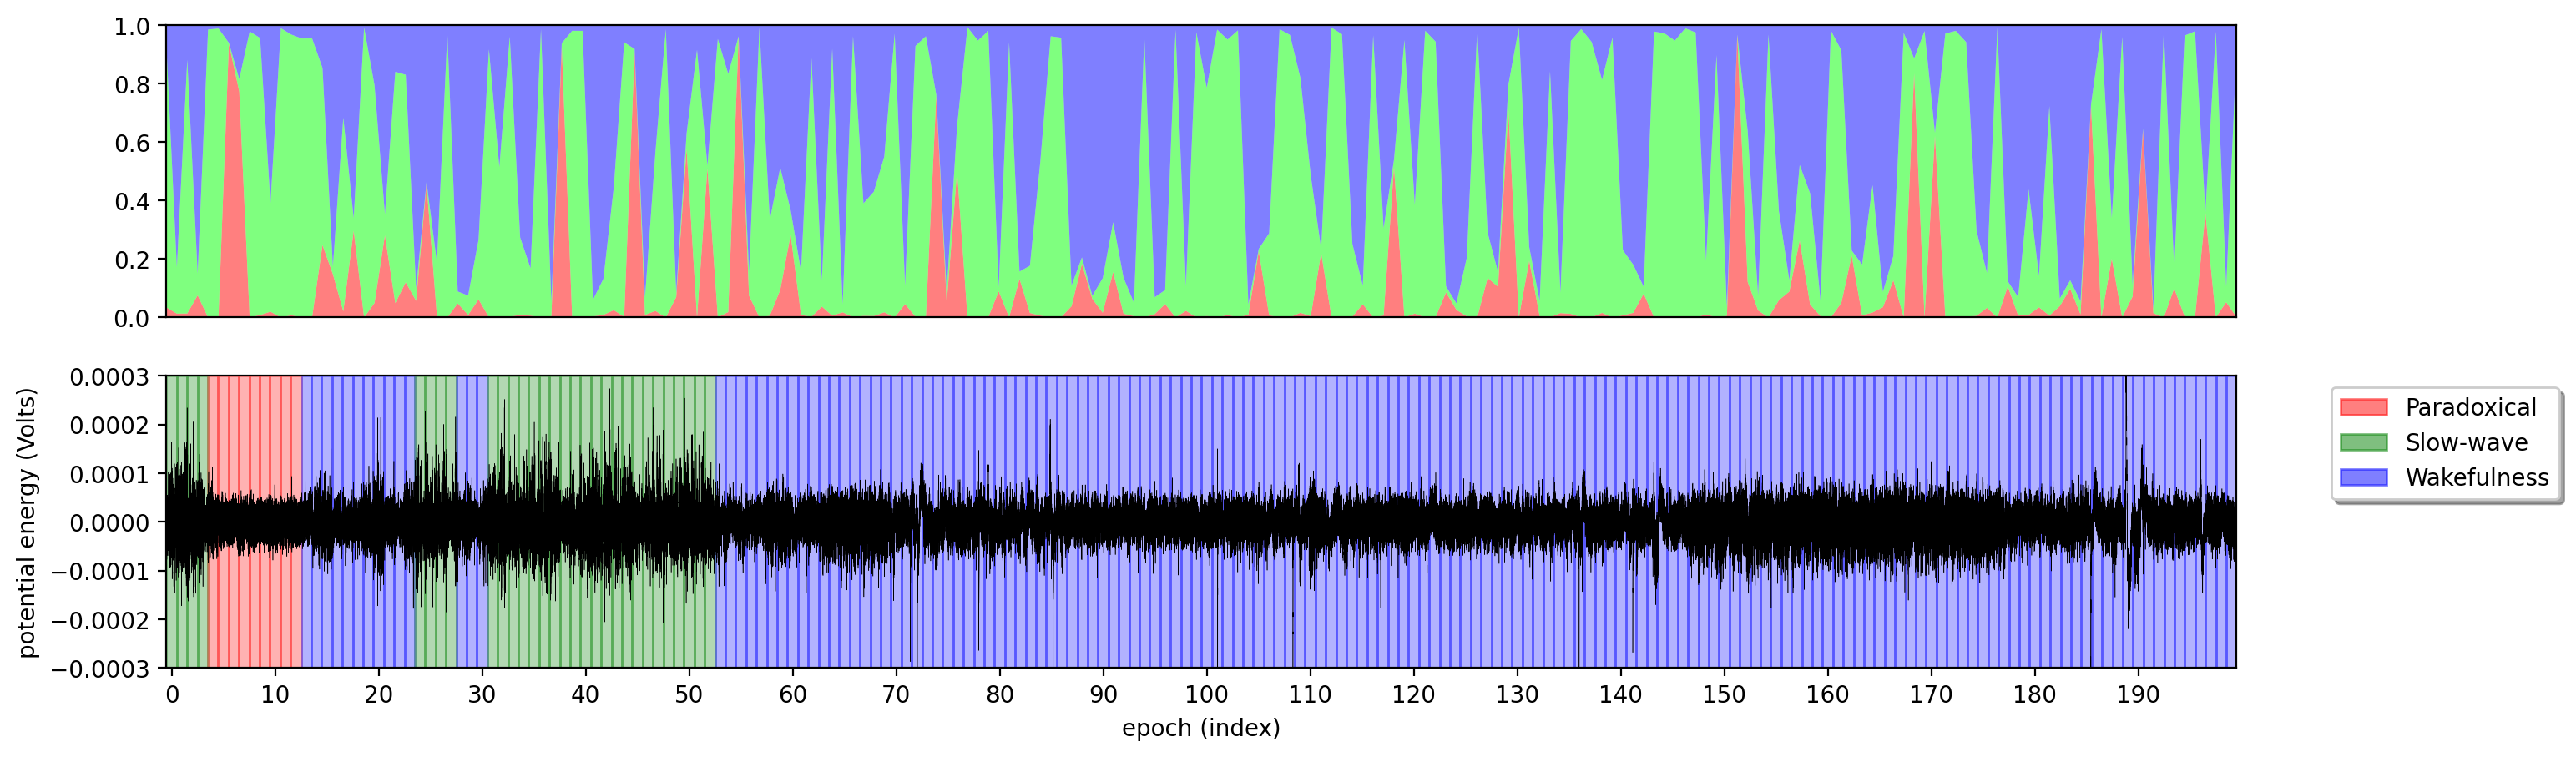

In [10]:
import matplotlib.patches as patches
start = 190
duration = 200
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,5),dpi=200)

ax[1].plot(X[start:start+duration].flatten(),'black',linewidth=.2)
colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[1].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
ax[1].set_ylim([-.0003,.0003])
ax[1].margins(0,0)
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (index)')
ax[1].set_ylabel('potential energy (Volts)')
ax[1].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);

ax[0].stackplot(torch.linspace(0,duration-1,duration),y_logits[start:start+duration,0],y_logits[start:start+duration,1],y_logits[start:start+duration,2],colors=['#FF000080','#00FF0080','#0000FF80'])
ax[0].margins(0,0)
ax[0].set_xticks([])